In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')

%matplotlib inline

## Case study 2: Coal mining disasters

Consider the following time series of recorded coal mining disasters in the UK from 1851 to 1962 (Jarrett, 1979). The number of disasters is thought to have been affected by changes in safety regulations during this period. Unfortunately, we also have pair of years with missing data, identified as missing by a NumPy MaskedArray using `-999` as the marker value.

Next we will build a model for this series and attempt to estimate when the change occurred. At the same time, we will see how to handle missing data, use multiple samplers and sample from discrete random variables.

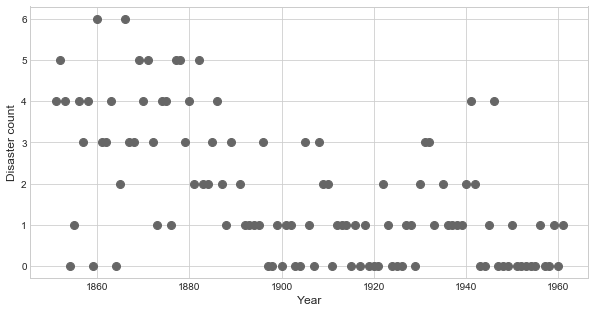

In [8]:
disaster_data = np.ma.masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                            2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                            0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                            3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)
year = np.arange(1851, 1962)
plt.rcParams['figure.figsize'] = 10, 5
plt.plot(year, disaster_data, 'o', markersize=8, color = '0.4' );
plt.ylabel("Disaster count")
plt.xlabel("Year")

Occurrences of disasters in the time series is thought to follow a Poisson process with a large rate parameter in the early part of the time series, and from one with a smaller rate in the later part. We are interested in locating the change point in the series, which perhaps is related to changes in mining safety regulations.

In our model,

$$
\begin{aligned}
D_t & \sim Pois(r_t), r_t = \begin{cases}
    l, & \text{if } t < s \\
    e, & \text{if } t \geq s
  \end{cases} \\
s & \sim Unif(t_l, t_h) \\
e & \sim Exp(1) \\
l & \sim Exp(1) \\
\end{aligned}
$$

the parameters are defined as follows: * $Dt$: The number of disasters in year $t$ * $r_t$: The rate parameter of the Poisson distribution of disasters in year $t$. * $s$: The year in which the rate parameter changes (the switchpoint). * $e$: The rate parameter before the switchpoint $s$. * $l$: The rate parameter after the switchpoint ss. * $t_l, t_h$: The lower and upper boundaries of year $t$.

This model is built much like our previous models. The major differences are the introduction of discrete variables with the Poisson and discrete-uniform priors and the novel form of the deterministic random variable `rate`.

In [9]:

with pm.Model() as disaster_model:

    switchpoint = pm.DiscreteUniform('switchpoint', lower=year.min(), upper=year.max(), testval=1900)

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential('early_rate', 1)
    late_rate = pm.Exponential('late_rate', 1)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= year, early_rate, late_rate)

    disasters = pm.Poisson('disasters', rate, observed=disaster_data)
    

The logic for the rate random variable,

    rate = pm.math.switch(switchpoint >= year, early_rate, late_rate)
   
is implemented using switch, a Theano function that works like an if statement. It uses the first argument to switch between the next two arguments.

Missing values are handled transparently by passing a `MaskedArray` or a `pandas.DataFrame` with `NaN` values to the observed argument when creating an observed stochastic random variable. Behind the scenes, another random variable, disasters.missing_values is created to model the missing values. All we need to do to handle the missing values is ensure we sample this random variable as well.

Unfortunately because they are discrete variables and thus have no meaningful gradient, we cannot use NUTS for sampling `switchpoint` or the missing disaster observations. Instead, we will sample using a `Metroplis` step method, which implements *adaptive Metropolis-Hastings*, because it is designed to handle discrete values. PyMC3 automatically assigns the correct sampling algorithms.

In [10]:
with disaster_model:
    trace = pm.sample(10000)

Assigned Metropolis to switchpoint
Assigned NUTS to early_rate_log_
Assigned NUTS to late_rate_log_
Assigned Metropolis to disasters_missing
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 755.23it/s]


In the trace plot below we can see that there’s about a 10 year span that’s plausible for a significant change in safety, but a 5 year span that contains most of the probability mass. The distribution is jagged because of the jumpy relationship between the year switchpoint and the likelihood and not due to sampling error.

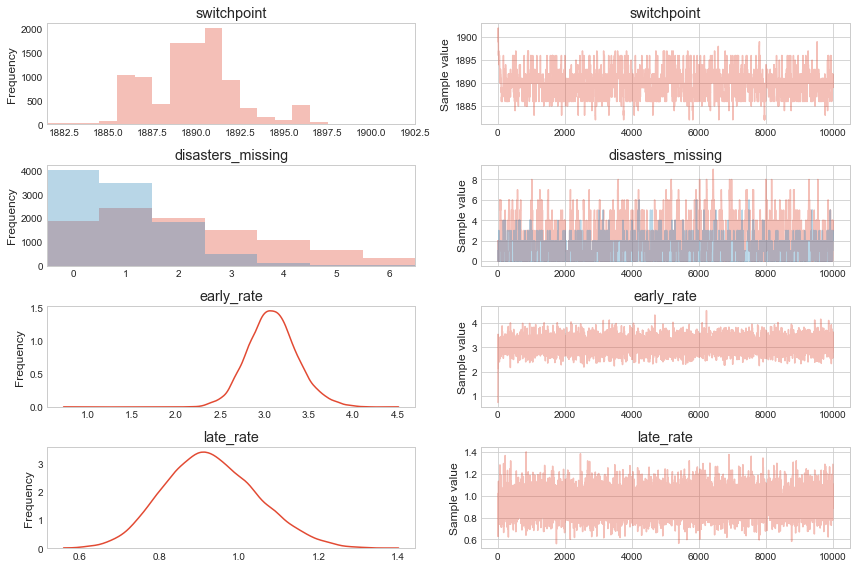

In [11]:
pm.traceplot(trace);

Arbitrary deterministics

Due to its reliance on Theano, PyMC3 provides many mathematical functions and operators for transforming random variables into new random variables. However, the library of functions in Theano is not exhaustive, therefore Theano and PyMC3 provide functionality for creating arbitrary Theano functions in pure Python, and including these functions in PyMC models. This is supported with the `as_op` function decorator.

Theano needs to know the types of the inputs and outputs of a function, which are specified for `as_op` by `itypes` for inputs and `otypes` for outputs. The Theano documentation includes an [overview of the available types](http://deeplearning.net/software/theano/library/tensor/basic.html#all-fully-typed-constructors).